In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub
!pip install librosa

In [1]:
import os
from os.path import isdir, join
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import random
import IPython
import io
import os
import glob
import sys
import librosa
sys.path.insert(1, '/content/drive/MyDrive/MCI/WordWakeup')
# from td_utils import *
%matplotlib inline

In [ ]:
# !unzip /content/drive/MyDrive/MCI/WakeupWord/negative.zip -d /content/drive/MyDrive/MCI/WordWakeup/

In [2]:
def load_raw_audio(current_path):
    activates = []
    activate_names = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(current_path+'/positive'):
        if filename.endswith("wav"):
            if(filename.split('_')[0] not in activate_names):
              activate = AudioSegment.from_wav(current_path+'/positive/'+filename)
              activates.append(activate)
              activate_names.append(filename.split('_')[0])
    for filename in os.listdir(current_path+'/background'):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(current_path+'/background/'+filename)
            backgrounds.append(background)
    for filename in os.listdir(current_path+'/negative'):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(current_path+'/negative/'+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds


In [3]:
# Load audio segments using pydub 
current_path = '/content/drive/MyDrive/MCI/WordWakeup'
activates, negatives, backgrounds = load_raw_audio(current_path)

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 


background len: 10000
activate[0] len: 1000
activate[1] len: 1000


In [154]:
def get_random_time_segment(segment_ms):
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   
    segment_end = segment_start + segment_ms - 1
    return (segment_start, segment_end)



def is_overlapping(segment_time, previous_segments):
    segment_start, segment_end = segment_time
    overlap = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    return overlap

def insert_audio_clip(background, audio_clip, previous_segments):
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)
    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
    return new_background, segment_time

def insert_ones(y, segment_end_ms):
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1
    return y

def create_training_example(background,
                            random_activates, 
                            random_negatives,
                            path, 
                            name):
    #np.random.seed(18)
    # Make background quieter
    background = background - 20
    y = np.zeros((1,Ty))
    previous_segments = []

    for random_activate in random_activates:
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)

    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    background = match_target_amplitude(background, -20.0)
    file_handle = background.export(path +name+ ".wav", format="wav")
    samples, sample_rate = librosa.load(path +name+ ".wav", sr = 16000)
    if(samples.shape[0] > 0 ):
      samples = librosa.resample(samples, sample_rate, 8000)
    return samples, y

In [155]:
import shutil
shutil.rmtree('/content/drive/MyDrive/MCI/WordWakeup/train')

In [9]:
background_names = []
for filename in os.listdir('/content/drive/MyDrive/MCI/WordWakeup/background/'):
        if filename.endswith("wav"):
            background_names.append(filename.split('_')[0])

background_names_set = set(background_names)

In [10]:
backgrounds = []
unique_set = []
for filename in os.listdir('/content/drive/MyDrive/MCI/WordWakeup/background/'):
  if filename.endswith("wav"):
      if(filename.split('_')[0] not in unique_set):
        background = AudioSegment.from_wav('/content/drive/MyDrive/MCI/WordWakeup/background/'+filename)
        backgrounds.append(background)
        unique_set.append(filename.split('_')[0])


In [12]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


In [156]:
Ty = 984 
X = []
Y = []
count = 0

for k in range(2):
  for background in backgrounds:
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    x, y = create_training_example(background, 
                                    random_activates,
                                    random_negatives,
                                    '/content/drive/MyDrive/MCI/WordWakeup/train/',
                                    str(count))

    if(x.shape[0]>0):
      X.append(x)
      Y.append(y)
      count+=1

In [157]:
X = np.asarray(X).reshape(-1,80000,1)
Y = np.asarray(Y).reshape(-1,984)

print(f'X shape is:{X.shape}')
print(f'Y shape is:{Y.shape}')

X shape is:(1482, 80000, 1)
Y shape is:(1482, 984)


In [158]:
np.save('/content/drive/MyDrive/MCI/WordWakeup/X', X)
np.save('/content/drive/MyDrive/MCI/WordWakeup/Y', Y)

In [159]:
import IPython.display as ipd

sample_path = '/content/drive/MyDrive/MCI/WordWakeup' +"/train/234.wav"
samples,sample_rate = librosa.load(sample_path)

ipd.Audio(samples, rate=sample_rate)

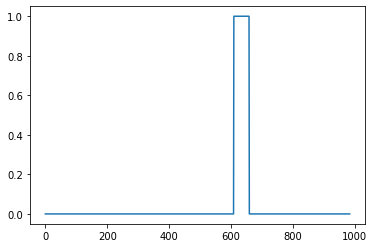

In [160]:
plt.plot(Y[234])

In [161]:
data_len = X.shape[0]
train_size = int(data_len*0.3)
test_size = (data_len - train_size )/ 2
all_indx = [i for i in range(data_len)]
msk_train = random.sample(range(data_len),train_size)
msk_other = [i for i in all_indx if i not in msk_train]
mask_test = np.random.choice(msk_other, size=train_size, replace=False)
mask_valid = [i for i in msk_other if i not in mask_test]

x_train = X[msk_train] 
y_train = Y[msk_train]

x_test = X[mask_test] 
y_test = Y[mask_test]

x_val = X[mask_valid] 
y_val = Y[mask_valid]


In [137]:
# GRADED FUNCTION: model
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D,MaxPooling1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Flatten
from keras.optimizers import Adam

def model(input_shape):
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    X = Conv1D(8,13, padding='valid', strides=1)(X_input)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)  
    X = Activation('relu')(X)
    X = MaxPooling1D(3)(X)

    #Second Conv1D layer
    X = Conv1D(16, 11, padding='valid', strides=1)(X)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)  
    X = Activation('relu')(X)
    X = MaxPooling1D(3)(X)

    # #Third Conv1D layer
    X = Conv1D(32, 9, padding='valid', strides=1)(X)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)  
    X = Activation('relu')(X)
    X = MaxPooling1D(3)(X)

    # #Third Conv1D layer
    X = Conv1D(16, 7, padding='valid', strides=1)(X)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)  
    X = Activation('relu')(X)
    X = MaxPooling1D(3)(X)

    # Step 2: First GRU Layer (≈4 lines)
    X = LSTM(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)     

    # Step 3: Second GRU Layer (≈4 lines)
    X = LSTM(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [138]:
model = model(input_shape = (80000,1))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 80000, 1)]        0         
                                                                 
 conv1d_16 (Conv1D)          (None, 79988, 8)          112       
                                                                 
 dropout_30 (Dropout)        (None, 79988, 8)          0         
                                                                 
 batch_normalization_23 (Bat  (None, 79988, 8)         32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 79988, 8)          0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 26662, 8)         0         
 g1D)                                                      

In [34]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [181]:
from sklearn.utils.class_weight import compute_class_weight
import keras

model.compile(
              # loss = 'binary_crossentropy',
              loss=[dice_coef_loss],
              optimizer='adam',
              metrics=[keras.metrics.Recall()]
              )
model.fit(x_train, y_train, batch_size = 256, epochs=20,
          validation_data = (x_val, y_val)
          )

Epoch 1/20
2/2 [==============================] - 12s 3s/step - loss: 0.4251 - recall_26: 0.6116 - val_loss: 0.4752 - val_recall_26: 0.7328
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 0.4361 - recall_26: 0.5507 - val_loss: 0.4941 - val_recall_26: 0.7378
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 0.4415 - recall_26: 0.5518 - val_loss: 0.4970 - val_recall_26: 0.7430
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 0.4266 - recall_26: 0.5878 - val_loss: 0.4766 - val_recall_26: 0.7474
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 0.4178 - recall_26: 0.5933 - val_loss: 0.4760 - val_recall_26: 0.7534
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.4134 - recall_26: 0.6229 - val_loss: 0.4912 - val_recall_26: 0.7600
Epoch 7/20
2/2 [==============================] - 3s 2s/step - loss: 0.4084 - recall_26: 0.6589 - val_loss: 0.4998 - val_recall_26: 0.7550
Epoch 8/20
2/2 [==========

In [188]:
model.evaluate(x_test, y_test, verbose=0)[1]

0.7508053183555603

In [186]:
model.save('/content/drive/MyDrive/MCI/WordWakeup/wakeup_model3.h5') 

In [45]:
def detect_triggerword(model,filename):
    # plt.subplot(2, 1, 1)
    samples, sample_rate = librosa.load(filename, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    predictions = model.predict(samples.reshape(1,80000,1))
    prd = (predictions[0,:,0]>0.5).astype(int)    
    plt.subplot(2, 1, 2)
    plt.plot(prd)
    plt.ylabel('probability')
    plt.show()
    return predictions

In [187]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/MCI/WordWakeup/wakeup_model2.h5',
                   custom_objects={'dice_coef_loss': dice_coef_loss})


1/1 [==============================] - 1s 773ms/step


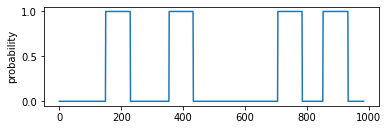

In [189]:
test_indx = mask_test[102]
filename = "/content/drive/MyDrive/MCI/WordWakeup/train/" + str(test_indx) + ".wav"
prediction = detect_triggerword(model,filename)
IPython.display.Audio(filename)


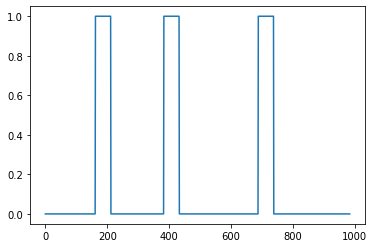

In [190]:
plt.plot(Y[test_indx])

In [ ]:
chime_file = "/content/drive/MyDrive/MCI/WordWakeup/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')